<a href="https://colab.research.google.com/github/jeffersonrodriguezc/deep-learning-en-3-semanas/blob/main/semana_2/notebooks/Nb_2c_Traduccion_usando_transformers_keras_sindetalles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explicando la Mejora de los Transformers sobre las RNNs
> Última actualización 20/02/2026



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeffersonrodriguezc/deep-learning-en-3-semanas/blob/main/semana_2/notebooks/Nb_2c_Traduccion_usando_transformers_keras_sindetalles.ipynb)

In [1]:
#@title Importar librerías
#importar librerías necesarias
import os
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

import warnings
warnings.filterwarnings('ignore')

In [2]:
#@title Funciones complementarias
def plot_similaridad_positional_encodings(pos_encoding):
  # normalización de los vectores a 1
  pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
  # seleccionamos el vector de la posición 1000
  p = pos_encoding[1000]
  # cálculo de la similitud del producto punto
  dots = tf.einsum('pd,d -> p', pos_encoding, p)

  # visualización de la relación de los vectores con sus palabras
  # vecinas, por definición tendran mucha similaridad.
  plt.subplot(2,1,1)
  plt.plot(dots)
  plt.ylim([0,1])
  plt.plot([950, 950, float('nan'), 1050, 1050],
          [0,1,float('nan'),0,1], color='k', label='Zoom')
  plt.legend()
  plt.subplot(2,1,2)
  plt.plot(dots)
  plt.xlim([950, 1050])
  plt.ylim([0,1])

def plot_distribucion_longitudes_tokens(all_lengths):
  plt.hist(all_lengths, np.linspace(0, 500, 101))
  plt.ylim(plt.ylim())
  max_length = max(all_lengths)
  plt.plot([max_length, max_length], plt.ylim())
  plt.title(f'Número máximo de tokens por muestra: {max_length}');

def plot_positional_encodings(pos_encoding):
  # Gráficar las dimensiones
  plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
  plt.ylabel('Profundidad')
  plt.xlabel('Posición')
  plt.colorbar()
  plt.show()

def plot_lr_planificador(learning_rate):
  plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
  plt.ylabel('Learning Rate');
  plt.xlabel('Paso de entrenamiento');

def plot_attention_head(in_tokens, translated_tokens, attention):
  # Saltar el token start.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(12, 15))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

def plot_traduccion(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Predicción":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

**Los Transformers: Una Nueva Era en el Procesamiento de Secuencias**

Las Redes Neuronales Recurrentes (RNNs) han sido una herramienta fundamental para el procesamiento de datos secuenciales, como el lenguaje natural. Sin embargo, los Transformers, propuestos en el artículo ["Attention is all you need"](https://arxiv.org/abs/1706.03762), han revolucionado este campo, ofreciendo ventajas significativas sobre las RNNs. **Los Transformers son redes neuronales profundas que reemplazan las CNNs y las RNNs. Estos introducen la auto-atención (self-attention) permite a los Transformers transmitir información fácilmente a través de las secuencias de entrada.**

**¿Por qué los Transformers son importantes?**

* **Paralelización:** A diferencia de las RNNs, los Transformers pueden procesar todos los elementos de una secuencia en paralelo, lo que permite un entrenamiento mucho más rápido en hardware moderno como GPUs y TPUs.
* **Captura de dependencias temporales de larga duración:** Los Transformers utilizan mecanismos de atención que permiten a cada posición de la secuencia prestar atención a todas las demás posiciones, facilitando el aprendizaje de relaciones entre elementos distantes. Las RNNs tienen dificultades para esto debido a la necesidad de procesar la secuencia paso a paso.
* **Flexibilidad:** Los Transformers no hacen suposiciones sobre las relaciones temporales o espaciales en los datos, lo que los hace aplicables a una variedad de tareas más allá del lenguaje, como el procesamiento de imágenes o el análisis de juegos.

En este notebook, exploraremos en profundidad los componentes clave de los Transformers y compararemos su funcionamiento con el de las RNNs, destacando las razones de su superioridad.

### Comparativa RNNs vs Transformers

<table>
<tr>
  <th><a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Modelo de Atención</a></th>
  <th>Transformer de 1 capa</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

## Esquema de trabajo

Con lo anterior en mente, y una vez visto un poco las diferencias entre RNNs y Transformers, vamos a abordar los siguientes contenidos de manera detallada:

1.  Prepararás los datos.
2.  Implementarás los componentes necesarios:
    * Embeddings posicionales.
    * Capas de atención.
    * El codificador y el decodificador.
3.  Construirás y entrenarás el Transformer.
4.  Generarás traducciones.
5.  Exportarás el modelo.

### Carga y Preprocesamiento de Datos

Cargaremos un conjunto de datos de traducción Portugués-Inglés y utilizaremos un tokenizador para preparar el texto para el modelo. Este conjunto de datos contiene aproximadamente 52.000 ejemplos de entrenamiento, 1.200 de validación y 1.800 de prueba.


In [20]:
# 1. Cargamos el dataset
dataset_name = 'tatoeba/tatoeba_pt'
dataset, info = tfds.load(dataset_name, with_info=True)

# 2. Función de mapeo para obtener la tupla (pt, en)
# Usamos las llaves definidas en tu Builder: source_sentence y target_sentence
def map_to_tuple(example):
    return example['source_sentence'], example['target_sentence']

# 3. Aplicamos el mapeo a todo el conjunto disponible
all_examples = dataset['train'].map(map_to_tuple)

# 4. División manual: 90% entrenamiento, 10% validación
num_examples = info.splits['train'].num_examples
train_size = int(0.9 * num_examples)

train_examples = all_examples.take(train_size)
val_examples = all_examples.skip(train_size)

# 5. Verificación de los resultados
print(f"Total de ejemplos en Tatoeba: {num_examples}")
print(f"Ejemplos asignados a train_examples: {train_size}")
print(f"Ejemplos asignados a val_examples: {num_examples - train_size}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tatoeba/tatoeba_pt/incomplete.8AM81M_1.0.0/tatoeba-train.tfrecord-[0-9][0-…

Dataset tatoeba downloaded and prepared to /root/tensorflow_datasets/tatoeba/tatoeba_pt/1.0.0. Subsequent calls will reuse this data.
Total de ejemplos en Tatoeba: 1000
Ejemplos asignados a train_examples: 900
Ejemplos asignados a val_examples: 100


In [21]:
# Mostrar algunos ejemplos de parejas de oraciones
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('-> Ejemplos en portugués:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('-> Traducción al inglés:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

-> Ejemplos en portugués:
Nós fomos de canoa rio abaixo.

Bom, está ficando tarde. Agora vamos.

Eu quero fazer algo interessante.


-> Traducción al inglés:
We canoed downstream.

Well, it's getting late. Let's go now.

I want to do something interesting.



#### Tokenizadores

En nuestro ejemplo vamos a usar los tokenizadores construidos en el tutorial [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer). Ese tutorial optimiza dos objetos `text.BertTokenizer` (uno para inglés, otro para portugués) para **este conjunto de datos** y los exporta en formato `saved_model` de TensorFlow.

In [22]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'./ted_hrlr_translate_pt_en_converter_extracted'

In [23]:
# cargar los tokenizadores
tokenizers = tf.saved_model.load(f'{model_name}_extracted/{model_name}')

In [24]:
# ambos tokenizadores tienen los mismo métodos
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [25]:
# por ejemplo revisemos los vocab
tokenizers.en.vocab.shape, tokenizers.pt.vocab.shape

(TensorShape([7010]), TensorShape([7765]))

El método `tokenize` convierte un grupo de oraciones en un grupo de identificadores de tokens de una misma longitud (padding). Este método separa los signos de puntuación, las minúsculas y normaliza el texto de entrada antes de la tokenización. Esta normalización no es visible aquí porque los datos de entrada ya están normalizados.

In [26]:
print('-> Esto es un grupo de cadenas:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

-> Esto es un grupo de cadenas:
We canoed downstream.

Well, it's getting late. Let's go now.

I want to do something interesting.



In [27]:
encoded = tokenizers.en.tokenize(en_examples)

print('-> Este es el grupo de cedena de ID de tokens (sin padding)')
for row in encoded.to_list():
  print(row)

-> Este es el grupo de cedena de ID de tokens (con padding)
[2, 78, 94, 4868, 178, 210, 773, 4319, 15, 3]
[2, 157, 13, 76, 9, 55, 361, 1086, 15, 186, 9, 55, 164, 110, 15, 3]
[2, 45, 158, 73, 91, 173, 374, 15, 3]


El método `detokenize` convierte los ID de token de nuevo en texto legible normal:

In [28]:
round_trip = tokenizers.en.detokenize(encoded)

print('-> Correspondiente texto:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

-> Correspondiente texto:
we canoed downstream .
well , it ' s getting late . let ' s go now .
i want to do something interesting .


El método `lookup` convierte de token-IDs a token-texto:

In [29]:
print('-> Este es el texto dividido en tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

-> Este es el texto dividido en tokens:


<tf.RaggedTensor [[b'[START]', b'we', b'can', b'##oe', b'##d', b'down', b'##st', b'##ream',
  b'.', b'[END]']                                                         ,
 [b'[START]', b'well', b',', b'it', b"'", b's', b'getting', b'late', b'.',
  b'let', b"'", b's', b'go', b'now', b'.', b'[END]']                      ,
 [b'[START]', b'i', b'want', b'to', b'do', b'something', b'interesting',
  b'.', b'[END]']                                                       ]>

Ten en cuenta que el texto tokenizado incluye los tokens `'[START]'` y `'[END]'`.

#### Configuración del pipeline de datos usando `tf.data`

La siguiente función toma batches de texto como entrada y los convierte a un formato adecuado para el entrenamiento.

1.  Los tokeniza en lotes de diferentes dimensiones (ragged).
2.  Recorta cada uno para que no tenga más de `MAX_TOKENS`.
3.  Divide los tokens objetivo (inglés) en entradas y etiquetas. Estos se desplazan un paso de modo que en cada ubicación de entrada, la `etiqueta` es el ID del siguiente token.
4.  Convierte los `RaggedTensor` en `Tensor` densos con padding.
5.  Devuelve un par `(entradas, etiquetas)`.


In [30]:
MAX_TOKENS=64
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt) # la sálida tiene diferentes longitudes
    pt = pt[:, :MAX_TOKENS]    # Truncar al max # de tokens
    pt = pt.to_tensor()  # Convertir a un tensor denso con padding

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)] # para poder hacer el shift
    en_inputs = en[:, :-1].to_tensor()  # Elimina los tokens [END]
    en_labels = en[:, 1:].to_tensor()   # Eliminar los tokens [START]

    return (pt, en_inputs), en_labels

La siguiente función convierte un conjunto de datos de ejemplos de texto en datos de lotes para el entrenamiento.

1.  Tokeniza el texto y filtra las secuencias que son demasiado largas.
2.  El método `cache` asegura que ese trabajo solo se ejecute una vez.
3.  Luego, `shuffle` y preparar el batch.
4.  Finalmente, `prefetch` ejecuta el conjunto de datos en paralelo con el modelo para asegurar que los datos estén disponibles cuando se necesiten. Consulta [Mejorar rendimiento con `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) para más detalles.

In [31]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [32]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

#### Probar nuestro pipeline de datos

In [33]:
# Crear los conjuntos de entrenamiento y validación
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

Como se verían las entradas y sálidas en nuestro pipeline de datos?


<table>
<tr>
  <th>Inputs en la parte inferior, labels en la parte superior.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

Esta configuración se llama "**teacher forcing**" porque, independientemente de la salida del modelo en cada paso de tiempo, recibe el valor verdadero como entrada para el siguiente paso de tiempo. Esta es una forma simple y eficiente de entrenar un modelo de generación de texto. Es eficiente porque no necesitas ejecutar el modelo secuencialmente; las salidas en las diferentes ubicaciones de la secuencia se pueden calcular en paralelo.

In [34]:
# visualizar un ejemplo de nuestros datos para entrenar
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 20)
(64, 19)
(64, 19)


Las etiquetas `en` y `en_labels` son las mismas, sólo que desplazadas en 1:

In [35]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2 2696  363 4207   90  126  378   15    0    0], shape=(10,), dtype=int64)
tf.Tensor([2696  363 4207   90  126  378   15    3    0    0], shape=(10,), dtype=int64)


### Definir los componentes del Transformer

Dentro de un Transformer pasan muchas cosas. Las cosas importantes que hay que recordar son:

*   Sigue el mismo patrón general que un modelo estándar secuencia-a-secuencia con un codificador y un decodificador.
*   Si trabajas paso a paso, todo tendrá sentido.

<table>
<tr>
  <th colspan=1>Diagrama original del Transformer</th>
  <th colspan=1>Representación de un Transformer de 4 capas</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

#### La capa para la codificación de la posición

Las entradas tanto del codificador como del descodificador utilizan la misma lógica de incrustación y codificación posicional

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

Dada una secuencia de tokens, tanto los tokens de entrada (portugués) como los tokens objetivo (inglés) deben convertirse en vectores utilizando una capa `tf.keras.layers.Embedding`.

Las capas de atención utilizadas en todo el modelo ven su entrada como un conjunto de vectores, sin ningún orden. Dado que el modelo no contiene ninguna capa recurrente o convolucional, necesita alguna forma de identificar el orden de las palabras; de lo contrario, vería la secuencia de entrada como una instancia de [bolsa de palabras](https://developers.google.com/machine-learning/glossary#bag-of-words), `cómo estás`, `cómo tú estás`, `tú cómo estás`, y así sucesivamente, son indistinguibles.

Por lo tanto, el Transformer agrega una "Codificación Posicional" a los vectores de embedding. Utiliza un conjunto de senos y cosenos en diferentes frecuencias (a lo largo de la secuencia). Por definición, los elementos cercanos tendrán codificaciones posicionales similares.

El paper original usa la siguiente formúla para la codificación posicional:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

Nota: El código a continuación lo implementa, pero en lugar de intercalar los senos y cosenos, los vectores de senos y cosenos simplemente se concatenan. Permutar los canales de esta manera es funcionalmente equivalente, y un poco más fácil de implementar y mostrar en las gráficas siguientes.

In [36]:
def positional_encoding(length, depth):
  depth = depth/2 # mitad de las dimensiones para cada función

  positions = np.arange(length)[:, np.newaxis]     # shape = (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # shape = (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

La función de codificación de posición es una pila de senos y cosenos que vibran a distintas frecuencias según su ubicación a lo largo de la profundidad del vector de incrustación. Vibran a través del eje de posición.

In [37]:
# para el ejemplo de la frase: El gato esta en la alfombra
# en este caso se concatenaron las funciones
positional_encoding(length=6, depth=4)

<tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  1.        ,  1.        ],
       [ 0.84147096,  0.00999983,  0.5403023 ,  0.99995   ],
       [ 0.9092974 ,  0.01999867, -0.41614684,  0.9998    ],
       [ 0.14112   ,  0.0299955 , -0.9899925 ,  0.99955004],
       [-0.7568025 ,  0.03998933, -0.6536436 ,  0.9992001 ],
       [-0.9589243 ,  0.04997917,  0.2836622 ,  0.99875027]],
      dtype=float32)>

(2048, 512)


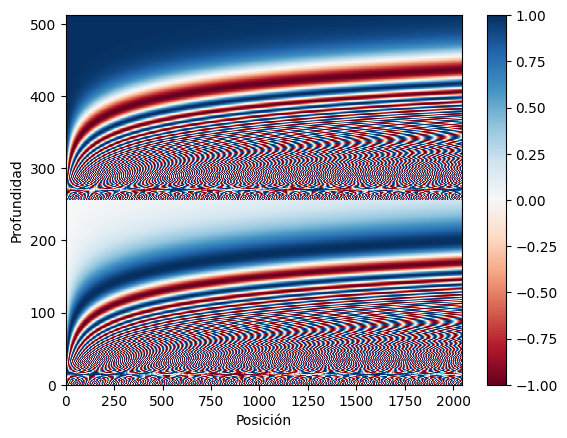

In [38]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Revisar la dimensión
print(pos_encoding.shape)

plot_positional_encodings(pos_encoding)

Ahora creemos la capa: `PositionEmbedding`

In [39]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # Este factor establece la escala relativa de la incrustación y la codificación_positonal.
    # Es decir asegurar que tengan escalas similares
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    # Se suma las posiciones a los embeddings de los tokens
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [40]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size().numpy(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size().numpy(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [41]:
pt_emb

<tf.Tensor: shape=(64, 20, 512), dtype=float32, numpy=
array([[[-0.5380007 ,  0.1628222 ,  0.774354  , ...,  1.4760675 ,
          1.1189824 ,  1.6478695 ],
        [ 1.0908726 ,  1.2446519 ,  1.5621033 , ...,  0.14956295,
          1.3023398 ,  0.6326418 ],
        [ 1.1426147 ,  1.2505121 ,  1.180898  , ...,  1.2539313 ,
          0.9629097 ,  0.08082807],
        ...,
        [-1.9622262 ,  0.41950828, -0.41719756, ...,  1.9860728 ,
          1.9698315 ,  0.7239084 ],
        [-1.7518158 ,  0.06065845, -1.1692518 , ...,  1.9860725 ,
          1.9698312 ,  0.7239083 ],
        [-0.85095143,  0.55930066, -1.2259063 , ...,  1.9860723 ,
          1.969831  ,  0.72390807]],

       [[-0.5380007 ,  0.1628222 ,  0.774354  , ...,  1.4760675 ,
          1.1189824 ,  1.6478695 ],
        [ 1.0624434 ,  1.6361681 ,  1.0501289 , ...,  0.58821464,
          1.2011144 ,  2.0381522 ],
        [-0.14702529,  0.9297227 ,  1.0296742 , ...,  1.0724392 ,
          0.16169178,  1.0027171 ],
        ...,

#### Capas de Adición y normalización

<table>
<tr>
  <th colspan=2>Add y normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

Estos bloques de "Add & Norm" se encuentran distribuidos a lo largo de todo el modelo Transformer. Cada uno combina una conexión residual y pasa el resultado a través de una capa de `LayerNormalization`.

La manera más sencilla de organizar el código es estructurándolo alrededor de estos bloques residuales. En las siguientes secciones, definiremos clases de capas personalizadas para cada uno de ellos.

Los bloques residuales "Add & Norm" se incluyen para que el entrenamiento sea eficiente. La conexión residual proporciona una ruta directa para el gradiente (y asegura que los vectores sean **actualizados** por las capas de atención en lugar de ser **reemplazados**), mientras que la normalización mantiene una escala razonable para las salidas.

**Nota**: Las implementaciones que se muestran a continuación utilizan la capa `Add` para asegurar que las máscaras de Keras se propaguen correctamente (el operador `+` no lo hace).



#### Bases de la capa de atención

Las capas de atención se utilizan a lo largo de todo el modelo Transformer. Todas ellas son idénticas, excepto por cómo se configura la atención. Cada una contiene una capa `layers.MultiHeadAttention`, una capa `layers.LayerNormalization` y una capa `layers.Add`.


<table>
<tr>
  <th colspan=2>Capa de atención básica</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

Para implementar estas capas de atención, comenzaremos con una clase base simple que sólo contenga definidos los componentes. Cada caso de uso se implementará como una subclase (framework).

In [42]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

##### **Capa de atención cruzada**

En el centro literal del Transformer está la capa de atención cruzada. Esta capa conecta el codificador y el decodificador. Esta capa es el uso más directo de la atención en el modelo, realiza la misma tarea que el bloque de atención en el [Tutorial NMT con atención](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

<table>
<tr>
  <th colspan=1>Atención cruzada</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

Para implementar esto, pasas la secuencia objetivo `x` como la `query` (consulta) y la secuencia de `context` (contexto) como la `key/value` (clave/valor) al llamar a la capa `mha`:


In [43]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Almacenar los scores de atención para
    # visualizarlos más adelante
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

Ejemplo:

In [44]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
# cada token de la frase en inglés
# será operados con todos los tokens de
# la oración en portugués, esto pasa así
# solo en entrenamiento
print(sample_ca(en_emb, pt_emb).shape)

(64, 20, 512)
(64, 19, 512)
(64, 19, 512)


##### **Capa global de auto-atención**

Esta capa se encarga de procesar la secuencia contextual y de propagar la información a lo largo de la misma:

<table>
<tr>
  <th colspan=1>La capa global de auto-atención</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

In [45]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [46]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 20, 512)
(64, 20, 512)


##### **Capa de auto-atención causal**

Esta capa realiza un trabajo similar al de la capa de autoatención global, para la secuencia de salida:


<table>
<tr>
  <th colspan=1>Capa causal de auto-atención</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

Esto debe tratarse de forma diferente a la capa de autoatención global del codificador.  

Los transformers son un modelo «autorregresivo»: Generan el texto un token a la vez y devuelven esa salida a la entrada. Para que esto sea _eficiente_, estos modelos garantizan que la salida de cada elemento de la secuencia solo dependa de los elementos anteriores de la secuencia; los modelos son «causales».

Para construir una capa de auto-atención causal, necesitas usar una máscara apropiada al calcular las puntuaciones de atención y sumar los `value`s de atención.

Esto se gestiona automáticamente si pasas `use_causal_mask = True` a la capa `MultiHeadAttention` cuando la llamas:

In [47]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

Ejemplo:

In [48]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 19, 512)
(64, 19, 512)


La salida de los primeros elementos de la secuencia no depende de los elementos posteriores, por lo que no debería importar si recorta los elementos antes o después de aplicar la capa:

In [49]:
# ejemplo donde la sálida debe ser cercana a cero
# ya que no deberia influir información posterior
out1 = sample_csa(embed_en(en[:, :3]))
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()
# nota omitir el warning por ahora

np.float32(7.1525574e-07)

#### La red feed forward (MLP)

El Transformer también incluye esta red neuronal feed-forward *point-wise* tanto en el codificador como en el decodificador:

<table>
<tr>
  <th colspan=1>La red feed forward (MLP)</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

La red consiste en dos capas lineales (`tf.keras.layers.Dense`) con una función de activación ReLU entre ellas, y una capa de dropout. Al igual que con las capas de atención, el código aquí también incluye la conexión residual y la normalización:

In [50]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x


Prueba:

In [51]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 19, 512)
(64, 19, 512)


#### La capa encoder

El codificador contiene una pila de `N` capas de codificador. Donde cada `EncoderLayer` contiene una capa `GlobalSelfAttention` y una capa `FeedForward`:

<table>
<tr>
  <th colspan=1>La capa encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

Aquí la estructura de la capa `EncoderLayer`:

In [52]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

Prueba:

In [53]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 20, 512)
(64, 20, 512)


#### El módulo Encoder

Construyamos el encoder, agregandole la parte de embedings y la codificación posicional.

<table>
<tr>
  <th colspan=1>El encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

El codificador consiste en:

- Una capa `PositionalEmbedding` en la entrada.
- Una pila de capas `EncoderLayer`.

In [54]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` es token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # añadir dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

Probar:

In [55]:
# Instanciar el Encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)
# Fijar training en false
sample_encoder_output = sample_encoder(pt, training=False)

# Dimensiones
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.
# ignorar los warnings

(64, 20)
(64, 20, 512)


#### La capa decoder

El decodificador es ligeramente más compleja, con cada `DecoderLayer` conteniendo una capa `CausalSelfAttention`, una capa `CrossAttention` y una capa `FeedForward`:


<table>
<tr>
  <th colspan=1>La capa decoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [56]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Solo para efectos de visualización posterior
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

Probar la capa del decoder:

In [57]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 19, 512)
(64, 20, 512)
(64, 19, 512)


#### El módulo decoder

De forma similar al Codificador, el Decodificador consiste en un `PositionalEmbedding` y una pila de `DecoderLayer`'s:


<table>
<tr>
  <th colspan=1>Capa Decoder + Embedding + PE</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>

Definimos el Decoder extendiendo `tf.keras.layers.Layer`:

In [58]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` es token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # EL shape de x es (batch_size, target_seq_len, d_model).
    return x

Probar:

In [59]:
# Instanciar el decoder
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 19)
(64, 20, 512)
(64, 19, 512)


In [60]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 19, 20])

Una vez creados el codificador y el decodificador Transformer, es hora de construir el modelo Transformer y entrenarlo.

## El Transformer

You now have `Encoder` and `Decoder`. To complete the `Transformer` model, you need to put them together and add a final linear (`Dense`) layer which converts the resulting vector at each location into output token probabilities.

The output of the decoder is the input to this final linear layer.

<table>
<tr>
  <th colspan=1>El transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

Crea el `Transformer` extendiendo `tf.keras.Model`:

> Nota: El [artículo original](https://arxiv.org/pdf/1706.03762.pdf), sección 3.4, comparte la matriz de pesos entre la capa de embedding y la capa lineal final. Para mantener las cosas simples, este tutorial utiliza dos matrices de pesos separadas.

In [61]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # Para usar el `.fit` del modelo keras usted debe pasar
    # todas las inputs como el primer argumento
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Capa final densa lineal
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Eliminar las máscaras para que no afecten el cálculo del loss y métricas
      # b/250038731 --> relacionado con este bug que fue reportado
      del logits._keras_mask
    except AttributeError:
      pass

    # retornar la salida final
    return logits

### Hiperparámetros

Para mantener este ejemplo pequeño y relativamente rápido, el número de capas (`num_layers`), la dimensionalidad de los embeddings (`d_model`) y la dimensionalidad interna de la capa `FeedForward` (`dff`) se han reducido.

El modelo base descrito en el artículo original del Transformer utilizaba `num_layers=6`, `d_model=512` y `dff=2048`.

El número de cabezas de auto-atención será (`num_heads=4`).


In [62]:
num_layers = 2
d_model = 128
dff = 256
num_heads = 4
dropout_rate = 0.1

### Probemos el transformer

Instanciar el modelo `Transformer`:

In [63]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Probar

In [64]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 19)
(64, 20)
(64, 19, 7010)


In [65]:
# acceder a los scores de atención
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 4, 19, 20)


## Training

Tiempo de entrenar!!

### Configurar el optimizador

Utilizar el optimizador Adam con un planificador personalizado para la tasa de aprendizaje según la fórmula del Transformer original. [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [66]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instanciar el optimizador (`tf.keras.optimizers.Adam`):

In [67]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Probar el scheduler para el learning rate:

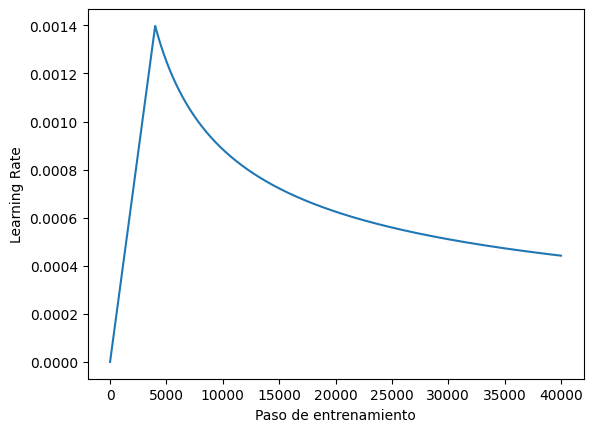

In [68]:
plot_lr_planificador(learning_rate)

### Ajustar función de pérdida y métricas

Dado que las secuencias objetivo están rellenadas (padded), es importante aplicar una máscara de padding al calcular la pérdida. Utiliza la función de pérdida de entropía cruzada (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [69]:
def masked_loss(label, pred):
  mask = label != 0 # Indica padding
  # from_logits=True indica que las predicciones no han pasado por softmax.
  # reduction='none' hace que se devuelva la pérdida por cada ejemplo.
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')

  loss = loss_object(label, pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  # Aplica la máscara a la pérdida, multiplicando las pérdidas de las posiciones
  # de padding por cero, lo que las elimina del cálculo total.
  loss *= mask

  # Calcula la pérdida promedio solo sobre las posiciones no enmascaradas.
  # Suma todas las pérdidas y divide por el número de posiciones no enmascaradas.
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  # Obtiene la clase predicha con la probabilidad más alta (el índice máximo)
  # a lo largo del eje de vocabulario (axis=2).
  pred = tf.argmax(pred, axis=2)
  # Convierte las etiquetas al mismo tipo de dato que las predicciones para comparar.
  label = tf.cast(label, pred.dtype)
  # Crea un tensor booleano donde True indica que la predicción coincide con la etiqueta.
  match = label == pred

  # Crea una máscara donde True indica que la etiqueta no es padding (no es 0).
  mask = label != 0

  # Combina la máscara con las coincidencias. Solo consideramos como "match"
  # las predicciones correctas en las posiciones que no son padding.
  match = match & mask

  # Convierte los booleanos de 'match' y 'mask' a float para poder calcular la media.
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  # Calcula la precisión promedio solo sobre las posiciones no enmascaradas.
  # Suma las coincidencias (1 para cada predicción correcta no enmascarada)
  # y divide por el número total de posiciones no enmascaradas.
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Entrenar el modelo

Con todo listo, vamos a compilar usando `model.compile`, y luego entrenar con `model.fit`:

In [70]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [71]:
transformer.fit(train_batches,
                epochs=10,
                validation_data=val_batches)

Epoch 1/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 158s 10s/step - loss: 8.8626 - masked_accuracy: 0.0000e+00 - val_loss: 8.8628 - val_masked_accuracy: 0.0000e+00
Epoch 2/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step - loss: 8.8472 - masked_accuracy: 0.0000e+00 - val_loss: 8.8248 - val_masked_accuracy: 0.0000e+00
Epoch 3/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 8.7976 - masked_accuracy: 3.3052e-04 - val_loss: 8.7620 - val_masked_accuracy: 7.6923e-04


## Ejecutar inferencia

Ahora puedes probar el modelo realizando una traducción. Los siguientes pasos se utilizan para la inferencia:

* Codifica la frase de entrada utilizando el tokenizador portugués (`tokenizers.pt`). Esta es la entrada del codificador.
* La entrada del decodificador se inicializa con el token `[START]`.
* Calcula las máscaras de padding y las máscaras causales (para la auto-atención causal).
* El `decodificador` luego genera las predicciones observando la `salida del codificador` y su propia salida (auto-atención).
* Concatena el token predicho a la entrada del decodificador y lo pasa de nuevo al decodificador.
* En este enfoque, el decodificador predice el siguiente token basándose en los tokens que predijo previamente.

Nota: El modelo está optimizado para un _entrenamiento eficiente_ y realiza una predicción del siguiente token para cada token en la salida simultáneamente. Esto es redundante durante la inferencia, y solo se utiliza la última predicción. Este modelo puede hacerse más eficiente para la inferencia si solo se calcula la última predicción cuando se ejecuta en modo de inferencia (`training=False`).

Define la clase `Translator` extendiendo `tf.Module`:

In [72]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # La frase de entrada es portugués, por lo que se añaden los tokens `[START]` y `[END]`.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # Como el lenguaje de sálida es inglés
    # Inicializar con el token `[START]`
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # con el TensorArray es posible hacer seguimiento al blucle dinámico
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      # convierte la lista de tokens generados secuencialmente
      # (almacenada en el TensorArray) en un tensor con la forma (1, secuencia_de_tokens),
      # donde la secuencia de tokens representa la traducción generada hasta ese punto.
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Seleccionar las predicciones para el último token de `seq_len`.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.
      # Encontrar la pos del token id con la mayor probabilidad
      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenar la predicción con los anteriores tokens del decoder.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # La dimensión de sálida es `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `@tf.function` optimiza la función, dificultando el acceso
    # a valores dinámicos en bucles. Recalculamos la atención
    # final fuera del bucle para obtener `attention_weights`.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

Nota: Esta función utiliza un bucle unrolled, no un bucle dinámico. Genera `MAX_TOKENS` en cada llamada. Consulta el tutorial de [NMT con atención](https://www.tensorflow.org/text/tutorials/nmt_with_attention) para ver un ejemplo de implementación con un bucle dinámico, que puede ser mucho más eficiente.

Probemos la traducción:

In [73]:
translator = Translator(tokenizers, transformer)

Ejemplo 1:

In [74]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
plot_traduccion(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Predicción     : meeting momentum over online over over over over over over over over over sugar rebuild sugar rebuild to over over over religion altruism altruism altruism altruism over over yes altruism chef chef over assigned sets altruism struggled altruismage over over over over over over over over over over overvatorageageub altruism click altruism delivered over over over over over over
Ground truth   : this is a problem we have to solve .


Ejemplo 2:

In [75]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
plot_traduccion(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Predicción     : meeting momentum over online over over over over over over over over over sugar rebuild sugar rebuild to over over over religion altruism altruism altruism altruism over over yes altruism altruism chef over assigned sets altruism struggled altruismage over over over over over over over over over over overvatorageageub altruism click altruism delivered over over over over over over
Ground truth   : and my neighboring homes heard about this idea .


Ejemplo 3:

In [76]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
plot_traduccion(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicción     : meeting momentum over margins edi over over over over over over over over sugar rebuild sugar rebuild to over over over religion altruism altruism altruism altruism over over yes altruism chef chef over assigned sets altruism struggled altruismating over over over over over over over over over over overvator informedageub altruism click altruism delivered over over over over over over
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## Crear los plots de atención

Usando la clase traductor `Translator` que almacena los scores de atención, podemos usarlos para ver su relevancia:

Por ejemplo:

In [77]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
plot_traduccion(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Predicción     : meeting momentum over online over over over over over over over over over sugar rebuild sugar rebuild to over over over religion altruism altruism altruism altruism over over yes altruism chef chef over assigned sets altruism struggled altruismage over over over over over over over over over over overvatorageageub altruism click altruism delivered over over over over over over
Ground truth   : this is the first book i've ever done.


Crear una función que grafique la atención cuando se genera un token:

In [78]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([64, 11])

Son las inputs tokens en portugués:

In [79]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

Estas son las sálidas (tokens en inglés, traducción)

In [80]:
translated_tokens

<tf.Tensor: shape=(65,), dtype=string, numpy=
array([b'[START]', b'meeting', b'momentum', b'over', b'online', b'over',
       b'over', b'over', b'over', b'over', b'over', b'over', b'over',
       b'over', b'sugar', b'rebuild', b'sugar', b'rebuild', b'to',
       b'over', b'over', b'over', b'religion', b'altruism', b'altruism',
       b'altruism', b'altruism', b'over', b'over', b'yes', b'altruism',
       b'chef', b'chef', b'over', b'assigned', b'sets', b'altruism',
       b'struggled', b'altruism', b'##age', b'over', b'over', b'over',
       b'over', b'over', b'over', b'over', b'over', b'over', b'over',
       b'over', b'##vator', b'##age', b'##age', b'##ub', b'altruism',
       b'click', b'altruism', b'delivered', b'over', b'over', b'over',
       b'over', b'over', b'over'], dtype=object)>

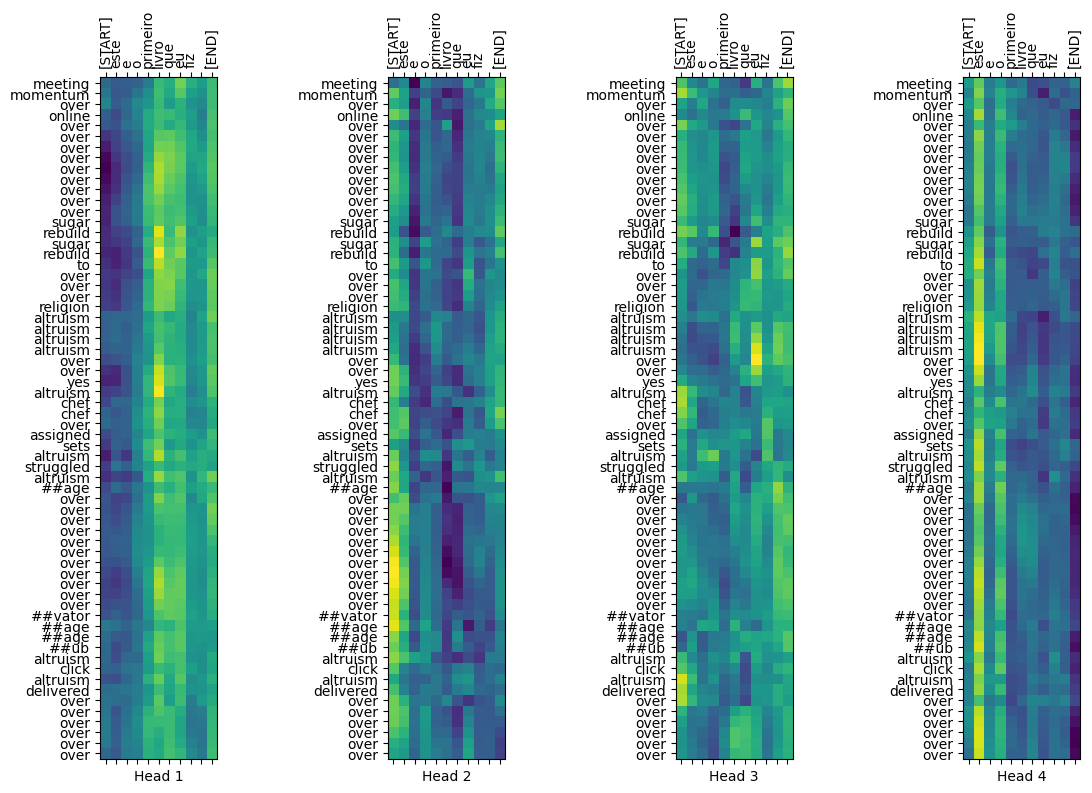

In [81]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

## Exportar el modelo

Hemos probado el modelo y la inferencia funciona. A continuación, puedes exportarlo como un `tf.saved_model`. Para aprender cómo guardar y cargar un modelo en formato SavedModel, consulta [esta guía](https://www.tensorflow.org/guide/saved_model).

Crea una clase llamada `ExportTranslator` extendiendo la subclase `tf.Module` con un `@tf.function` en el método `__call__`:

In [82]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [ ]:
# Empaqueta el objeto `translator` en la nueva clase `ExportTranslator` creada:
translator = ExportTranslator(translator)

Dado que el modelo está decodificando las predicciones utilizando `tf.argmax`, las predicciones son deterministas. El modelo original y uno recargado desde su `SavedModel` deberían dar predicciones idénticas:




In [ ]:
translator('este é o primeiro livro que eu fiz.').numpy()

In [ ]:
tf.saved_model.save(translator, export_dir='translator')

In [ ]:
reloaded = tf.saved_model.load('translator')

In [ ]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

## Conclusión

En este tutorial aprendiste sobre:

* Los Transformers y su importancia en el aprendizaje automático
* Atención, auto-atención y atención multi-cabeza
* Codificación posicional con embeddings
* La arquitectura codificador-decodificador del Transformer original
* Enmascaramiento en la auto-atención
* Cómo juntar todo para traducir texto

Las desventajas de esta arquitectura son:

- Para una serie temporal, la salida para un paso de tiempo se calcula a partir de la *historia completa* en lugar de solo las entradas y el estado oculto actual. Esto _podría_ ser menos eficiente.
- Si la entrada tiene una relación temporal/espacial, como texto o imágenes, debe añadirse alguna codificación posicional o el modelo efectivamente verá una bolsa de palabras.

*Este notebook se basó en el notebook de [Neural Machine Translation with a Transformer and Keras](https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb) para el curso de Deep Learning práctico en 3 semanas.*